In [ ]:
print("asdf")

hey


In [ ]:
import sys

sys.path.append("/home/dylan-kmutt/ubpd")

In [ ]:
from src.helper import get_train_test_pids

train_v_pids, test_pids = get_train_test_pids("../../data/dataset/images/", seed=42)
all_pids = train_v_pids + test_pids
len(all_pids)

88

In [4]:
from typing import List, Tuple
import random


def split_train_and_test(
    pids: List[int], seed: int = 42
) -> Tuple[List[int], List[int]]:
    if not pids:
        return [], []

    # De-duplicate while preserving order
    unique = list(dict.fromkeys(pids))
    n = len(unique)

    # Reproducible shuffle
    rng = random.Random(seed)
    idxs = list(range(n))
    rng.shuffle(idxs)
    shuffled = [unique[i] for i in idxs]

    # Compute test size (≈15%); keep at least 1 test if possible, and at least 1 train
    raw_test = int(round(n * 0.15))
    if n >= 2:
        test_size = max(1, min(raw_test, n - 1))
    else:
        test_size = 0  # only one item → all train

    test_ids = shuffled[:test_size]
    train_ids = shuffled[test_size:]

    return train_ids, test_ids

In [5]:
ultrasound_1_pids = [i for i in range(7, 44 + 1) if i in all_pids]

sub_1_ultrasound_2_pids = [i for i in range(47, 166 + 1) if i in all_pids]
sub_2_ultrasound_2_pids = [i for i in range(1, 6 + 1) if i in all_pids]
ultrasound_2_pids = sub_1_ultrasound_2_pids + sub_2_ultrasound_2_pids

print(f"# Patients in Ultrasound 1: {len(ultrasound_1_pids)}")
print(f"# Patients in Ultrasound 2: {len(ultrasound_2_pids)}")

# Patients in Ultrasound 1: 36
# Patients in Ultrasound 2: 52


In [6]:
seed = 33
u1_train_pids, u1_test_pids = split_train_and_test(ultrasound_1_pids, seed=seed)
u2_train_pids, u2_test_pids = split_train_and_test(ultrasound_2_pids, seed=seed)

# Combine (concat) and deduplicate while keeping order
comb_train_pids = list(dict.fromkeys(list(u1_train_pids) + list(u2_train_pids)))
comb_test_pids = list(dict.fromkeys(list(u1_test_pids) + list(u2_test_pids)))

# Optional: ensure no leakage between train/test
leak = set(comb_train_pids) & set(comb_test_pids)
if leak:
    comb_train_pids = [p for p in comb_train_pids if p not in leak]
    print("leak")
    # or raise an error/log, depending on your policy

print(f"Seed: {seed}\n")
print(f"Ultrasound 1: train {len(u1_train_pids)} pids, test {len(u1_test_pids)} pids")
print(f"  Train PIDs: {', '.join(map(str, u1_train_pids))}")
print(f"  Test  PIDs: {', '.join(map(str, u1_test_pids))}\n")

print(f"Ultrasound 2: train {len(u2_train_pids)} pids, test {len(u2_test_pids)} pids")
print(f"  Train PIDs: {', '.join(map(str, u2_train_pids))}")
print(f"  Test  PIDs: {', '.join(map(str, u2_test_pids))}\n")

print(f"Combined: train {len(comb_train_pids)} pids, test {len(comb_test_pids)} pids")
print(f"  Train PIDs: {', '.join(map(str, comb_train_pids))}")
print(f"  Test  PIDs: {', '.join(map(str, comb_test_pids))}")

Seed: 33

Ultrasound 1: train 31 pids, test 5 pids
  Train PIDs: 14, 15, 12, 11, 13, 35, 32, 40, 7, 30, 31, 25, 20, 34, 9, 41, 16, 43, 22, 36, 29, 44, 23, 27, 37, 28, 18, 39, 24, 21, 17
  Test  PIDs: 38, 19, 10, 42, 8

Ultrasound 2: train 44 pids, test 8 pids
  Train PIDs: 90, 99, 52, 84, 79, 93, 3, 94, 82, 50, 58, 2, 5, 60, 65, 75, 86, 4, 77, 48, 67, 68, 61, 81, 71, 51, 70, 83, 1, 100, 73, 87, 96, 166, 63, 88, 89, 98, 85, 69, 66, 97, 62, 92
  Test  PIDs: 131, 53, 6, 47, 78, 49, 76, 64

Combined: train 75 pids, test 13 pids
  Train PIDs: 14, 15, 12, 11, 13, 35, 32, 40, 7, 30, 31, 25, 20, 34, 9, 41, 16, 43, 22, 36, 29, 44, 23, 27, 37, 28, 18, 39, 24, 21, 17, 90, 99, 52, 84, 79, 93, 3, 94, 82, 50, 58, 2, 5, 60, 65, 75, 86, 4, 77, 48, 67, 68, 61, 81, 71, 51, 70, 83, 1, 100, 73, 87, 96, 166, 63, 88, 89, 98, 85, 69, 66, 97, 62, 92
  Test  PIDs: 38, 19, 10, 42, 8, 131, 53, 6, 47, 78, 49, 76, 64


In [7]:
def report_leak(tag, train_ids, test_ids):
    leak = set(train_ids) & set(test_ids)
    if leak:
        print(
            f"[LEAK] {tag}: {len(leak)} overlapping PID(s): {', '.join(map(str, sorted(leak)))}"
        )
    else:
        print(f"[OK]   {tag}: no leakage.")


# Per-dataset leakage
report_leak("Ultrasound 1", u1_train_pids, u1_test_pids)
report_leak("Ultrasound 2", u2_train_pids, u2_test_pids)

# Cross-dataset leakage (train of one vs test of the other)
report_leak("U1 train vs U2 test", u1_train_pids, u2_test_pids)
report_leak("U2 train vs U1 test", u2_train_pids, u1_test_pids)

# Combined leakage
report_leak("Combined", comb_train_pids, comb_test_pids)

[OK]   Ultrasound 1: no leakage.
[OK]   Ultrasound 2: no leakage.
[OK]   U1 train vs U2 test: no leakage.
[OK]   U2 train vs U1 test: no leakage.
[OK]   Combined: no leakage.


In [8]:
from src.helper import get_cv_pids

u1_cv_pids = get_cv_pids(u1_train_pids, cv=5)
u2_cv_pids = get_cv_pids(u2_train_pids, cv=5)

In [9]:
assert len(u1_cv_pids) == len(u2_cv_pids), "U1 and U2 must have the same # of folds"

comb_cv_pids: list[tuple[list[int], list[int]]] = []
for (u1_tr, u1_val), (u2_tr, u2_val) in zip(u1_cv_pids, u2_cv_pids):
    # concat + dedup while keeping order
    comb_tr = list(dict.fromkeys(list(u1_tr) + list(u2_tr)))
    comb_val = list(dict.fromkeys(list(u1_val) + list(u2_val)))

    # optional: sanity check for leakage within the fold
    leak = set(comb_tr) & set(comb_val)
    if leak:
        print(f"[LEAK] Combined fold has overlap: {sorted(leak)}")

    comb_cv_pids.append((comb_tr, comb_val))

In [10]:
def print_cv(name: str, cv_pids: list[tuple[list[int], list[int]]]) -> None:
    print(f"{name}: {len(cv_pids)} folds")
    for i, (train, val) in enumerate(cv_pids, start=1):
        print(f" Fold {i}: train {len(train)} pids, val {len(val)} pids")
        print(f"   Train: {', '.join(map(str, train))}")
        print(f"   Val  : {', '.join(map(str, val))}")
        leak = set(train) & set(val)
        if leak:
            print(
                f"   [LEAK] {len(leak)} overlapping PID(s): {', '.join(map(str, sorted(leak)))}"
            )
    print()


print_cv("Ultrasound 1 (CV)", u1_cv_pids)
print_cv("Ultrasound 2 (CV)", u2_cv_pids)
print_cv("Combined (CV)", comb_cv_pids)

Ultrasound 1 (CV): 5 folds
 Fold 1: train 25 pids, val 6 pids
   Train: 35, 20, 25, 41, 30, 18, 17, 23, 16, 24, 15, 34, 22, 12, 43, 44, 21, 13, 28, 40, 7, 27, 14, 11, 29
   Val  : 36, 9, 31, 37, 39, 32
 Fold 2: train 25 pids, val 6 pids
   Train: 36, 9, 31, 37, 39, 32, 17, 23, 16, 24, 15, 34, 22, 12, 43, 44, 21, 13, 28, 40, 7, 27, 14, 11, 29
   Val  : 35, 20, 25, 41, 30, 18
 Fold 3: train 25 pids, val 6 pids
   Train: 36, 9, 31, 37, 39, 32, 35, 20, 25, 41, 30, 18, 22, 12, 43, 44, 21, 13, 28, 40, 7, 27, 14, 11, 29
   Val  : 17, 23, 16, 24, 15, 34
 Fold 4: train 25 pids, val 6 pids
   Train: 36, 9, 31, 37, 39, 32, 35, 20, 25, 41, 30, 18, 17, 23, 16, 24, 15, 34, 28, 40, 7, 27, 14, 11, 29
   Val  : 22, 12, 43, 44, 21, 13
 Fold 5: train 24 pids, val 7 pids
   Train: 36, 9, 31, 37, 39, 32, 35, 20, 25, 41, 30, 18, 17, 23, 16, 24, 15, 34, 22, 12, 43, 44, 21, 13
   Val  : 28, 40, 7, 27, 14, 11, 29

Ultrasound 2 (CV): 5 folds
 Fold 1: train 36 pids, val 8 pids
   Train: 79, 88, 81, 2, 73, 68, 5,

In [11]:
def get_pids(seed, ultrasound):
    if seed == 42:
        if ultrasound == "u1":
            p_ids = [16, 19, 12, 36, 41]
        if ultrasound == "u2":
            p_ids = [61, 77, 79, 50, 75, 94, 68, 96]
        if ultrasound == "combined":
            p_ids = [16, 19, 12, 36, 41, 61, 77, 79, 50, 75, 94, 68, 96]
    elif seed == 94:
        if ultrasound == "u1":
            p_ids = [11, 35, 32, 9, 8]
        if ultrasound == "u2":
            p_ids = [50, 62, 98, 4, 81, 96, 70, 68]
        if ultrasound == "combined":
            p_ids = [11, 35, 32, 9, 8, 50, 62, 98, 4, 81, 96, 70, 68]
    elif seed == 33:
        if ultrasound == "u1":
            p_ids = [38, 19, 10, 42, 8]
        if ultrasound == "u2":
            p_ids = [131, 53, 6, 47, 78, 49, 76, 64]
        if ultrasound == "combined":
            p_ids = [38, 19, 10, 42, 8, 131, 53, 6, 47, 78, 49, 76, 64]
    return p_ids

In [12]:
import numpy as np
import os
import wandb

from src.dataset import UBPDataset
from src.preprocessing import PairedTransform
from src.train import Trainer
from src.evaluate import Evaluator
from src.helper import (
    set_seed,
    _build_model_factory,
    aggregate_fold_metrics,
)


def experiment(variants, exp_id, seed):
    # CV
    exp_id = str(exp_id)
    all_histories = []
    fold_overall_means = []
    fold_results = []  # store per-fold evaluator outputs (dicts)

    # exp_id = random.randint(int(1e5), int(1e6) - 1)
    model_name = variants["model"]

    set_seed(seed)
    print(f"\n🚀 Beginning experiment #{exp_id}")
    print("=" * 60)

    include_classes = variants.get("include_classes")
    class_names = {
        1: "dongmai (artery)",
        2: "jingmai (vein)",
        3: "jirouzuzhi (muscle)",
        4: "shenjing (nerve)",
    }
    print("Included classes:")
    for cid in include_classes:
        print(f"  {cid}: {class_names.get(cid, 'unknown')}")
    print(f"\n- Model: {model_name}")
    print(f"- Augment: {variants['augment']}")

    include_classes = variants["include_classes"]
    n_inc = len(include_classes)
    if n_inc == 1:
        variants["loss"] = "bce"
        num_classes_for_model = 1  # single foreground channel
        keep_original_indices = True  # irrelevant when binary
    else:
        variants["loss"] = "ce"
        num_classes_for_model = n_inc + 1  # background + selected classes only
        keep_original_indices = False  # remap selected IDs to contiguous {0..K}
    variants["num_classes"] = num_classes_for_model

    print(
        f"- Using loss='{variants['loss']}' with model num_classes={num_classes_for_model}"
    )
    if not keep_original_indices:
        print(
            "- Remapping labels to contiguous IDs: background=0, selected classes=1..K"
        )
    print(f"- Image size: {variants['image_size']}")
    print("-" * 60)

    if variants["dataset"] == "u1":
        test_pids = u1_test_pids
        cv_pids = u1_cv_pids
    if variants["dataset"] == "u2":
        test_pids = u2_test_pids
        cv_pids = u2_cv_pids
    if variants["dataset"] == "combined":
        test_pids = comb_test_pids
        cv_pids = comb_cv_pids

    paired_train_tf = PairedTransform(
        size=variants["image_size"], aug=variants["augment"]
    )
    paired_test_tf = PairedTransform(size=variants["image_size"], aug=False)
    test_dataset = UBPDataset(
        p_ids=test_pids,
        include_classes=include_classes,
        image_dir="../../data/dataset/images",
        json_dir="../../data/dataset/labels/json_train",
        joint_transform=paired_test_tf,
        keep_original_indices=True,
    )

    print("Test landmarks stat: ")
    test_dataset.print_stats()
    len(test_dataset)

    for fold in range(1, len(cv_pids) + 1):
        name = f"{exp_id}_fold_{fold}"
        if variants["use_wandb"]:
            api_key = os.getenv("WANDB_API_KEY")
            wandb.login(key=api_key)
            wandb.init(
                project="ubpd",
                group=exp_id,
                name=name,
                config=variants,
                reinit=True,
            )
        train_pids, val_pids = cv_pids[fold - 1]

        print(f"\n📂 Fold {fold}/{len(cv_pids)}")
        print(f"  Train patient IDs: {train_pids}")
        print(f"  Val   patient IDs: {val_pids}\n")

        train_dataset = UBPDataset(
            p_ids=train_pids,
            include_classes=include_classes,
            image_dir="../../data/dataset/images",
            json_dir="../../data/dataset/labels/json_train",
            joint_transform=paired_train_tf,
            keep_original_indices=keep_original_indices,  # <--- important
        )

        val_dataset = UBPDataset(
            p_ids=val_pids,
            include_classes=include_classes,
            image_dir="../../data/dataset/images",
            json_dir="../../data/dataset/labels/json_train",
            joint_transform=paired_test_tf,
            keep_original_indices=keep_original_indices,  # <--- important
        )

        print("Train landmarks stat: ")
        train_dataset.print_stats()
        print()
        print("Validation landmarks stat:")
        val_dataset.print_stats()
        val_dataset.visualize_image_transform(0)

        make_model = _build_model_factory(model_name)
        model = make_model(num_classes=num_classes_for_model)

        trainer = Trainer(
            exp_id=exp_id,
            fold_num=fold,
            model=model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            arguments=variants,
        )
        history = trainer.train()
        all_histories.append(history)

        if history["val_loss"]:
            best_idx = int(np.argmin(history["val_loss"]))
            print(
                f"  ✅ Best @ epoch {best_idx + 1}: val_loss={history['val_loss'][best_idx]:.4f} | val_dice={history['val_dice'][best_idx]:.4f}"
            )
        print("-" * 60)

        # Evaluate one fold (you can move this after the loop to evaluate the final/best model instead)
        evaluator = Evaluator(
            trainer.model,
            test_dataset,
            num_classes=num_classes_for_model,
            ignore_empty_classes=False,
        )
        res = evaluator.evaluate_dice_score(show_plot=True)
        evaluator.visualize_ranked()
        # collect overall mean dice for this fold if available
        try:
            overall_mean = res.get("overall", {}).get("mean", float("nan"))
        except Exception:
            overall_mean = float("nan")
        fold_overall_means.append(
            float(overall_mean) if overall_mean is not None else float("nan")
        )
        fold_results.append(res)

    overall_mean, overall_std, per_class_stats = aggregate_fold_metrics(fold_results)
    if not np.isnan(overall_mean):
        print(
            f"\n🎯 Average overall Dice across folds: {overall_mean:.4f} ± {overall_std:.4f}  (n={len(fold_results)})"
        )
    else:
        print("\n⚠️ No per-fold overall Dice scores collected.")

    # Print per-landmark (per-class) averages
    if per_class_stats:
        print("\n📌 Per-landmark average Dice across folds:")
        for cid in sorted(per_class_stats.keys()):
            stats = per_class_stats[cid]
            name = class_names.get(cid, f"class_{cid}")
            print(
                f"  {cid}: {name:<20s} mean±std: {stats['mean']:.4f} ± {stats['std']:.4f}  (folds={stats['n_folds']})"
            )
    else:
        print("\n⚠️ No per-class stats available to aggregate.")

    print("\n✅ Experiment complete across folds.")

    if variants["use_wandb"]:
        wandb.finish()

    return {
        "histories": all_histories,
        "test_dataset": test_dataset,
        "fold_overall_means": fold_overall_means,
    }

In [16]:
import torch

variants = {
    "model": "unet",
    "cv": 5,
    "include_classes": [1, 2, 3, 4],
    "dataset": "u2",
    "epochs": 100,
    "batch_size": 16,
    "num_workers": 2,
    "image_size": 512,
    "patience": 20,
    "scheduler": "plateau",
    "plateau_cooldown": 10,
    "half_precision": True,
    "ignore_empty": False,
    "augment": True,
    "cuda": "cuda" if torch.cuda.is_available() else "cpu",
    "use_wandb": True,
    "save_dir": "../../checkpoints",
}

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/dylan-kmutt/.netrc



🚀 Beginning experiment #222204
Included classes:
  1: dongmai (artery)
  2: jingmai (vein)
  3: jirouzuzhi (muscle)
  4: shenjing (nerve)

- Model: unet
- Augment: True
- Using loss='ce' with model num_classes=5
- Remapping labels to contiguous IDs: background=0, selected classes=1..K
- Image size: 512
------------------------------------------------------------
Test landmarks stat: 
Artery  present: 48/88 images
Vein    present: 43/88 images
Muscle  present: 55/88 images
Nerve   present: 88/88 images



📂 Fold 1/5
  Train patient IDs: [79, 88, 81, 2, 73, 68, 5, 51, 98, 85, 1, 60, 71, 67, 61, 100, 92, 90, 48, 86, 62, 89, 96, 97, 52, 83, 93, 63, 3, 82, 65, 75, 4, 99, 94, 66]
  Val   patient IDs: [50, 84, 58, 166, 69, 77, 87, 70]

Train landmarks stat: 
Artery  present: 261/432 images
Vein    present: 242/432 images
Muscle  present: 313/432 images
Nerve   present: 405/432 images

Validation landmarks stat:
Artery  present: 23/74 images
Vein    present: 19/74 images
Muscle  present: 45/74 images
Nerve   present: 74/74 images


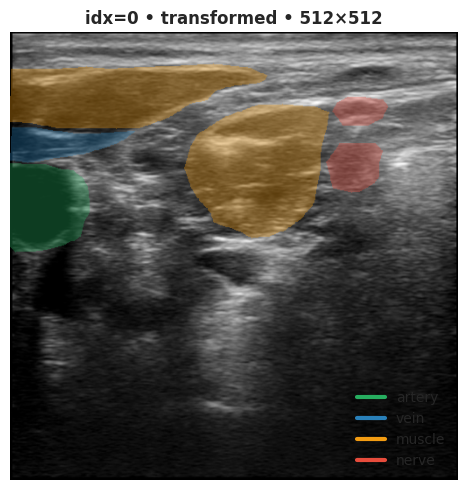

Epoch 001/100 | lr=1.000e-03 train_loss=1.2159 val_loss=0.7050 train_dice=0.0845 val_dice=0.4613 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.6675 val_loss=0.5383 train_dice=0.2274 val_dice=0.4361 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.5118 val_loss=0.4841 train_dice=0.2977 val_dice=0.4569 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.4174 val_loss=0.4013 train_dice=0.2740 val_dice=0.2895 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.3493 val_loss=0.4094 train_dice=0.2766 val_dice=0.4192  (patience 1/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.3114 val_loss=0.3750 train_dice=0.2907 val_dice=0.2099 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.2797 val_loss=0.3670 train_dice=0.3223 val_dice=0.3167 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.2449 val_loss=0.4793 train_dice=0.3943 val_dice=0.2072  (patience 1/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.2301 val_l

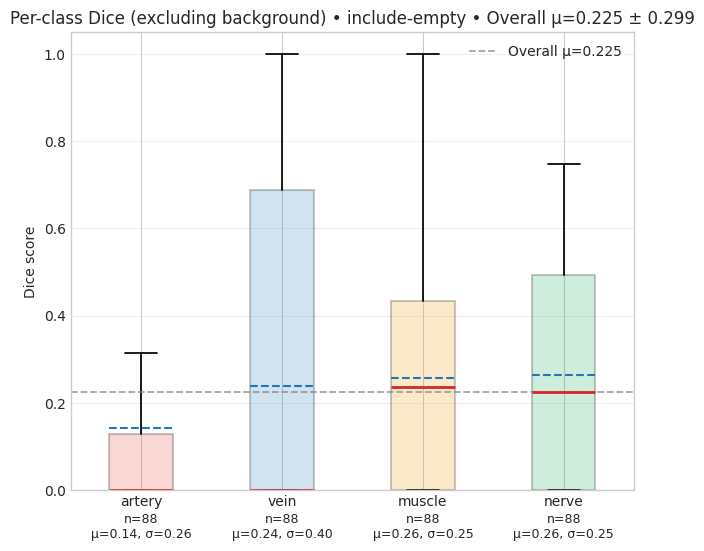

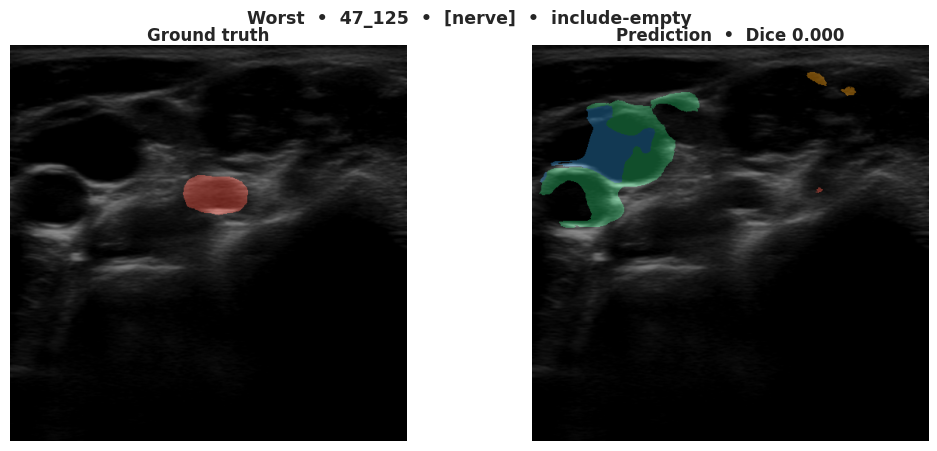

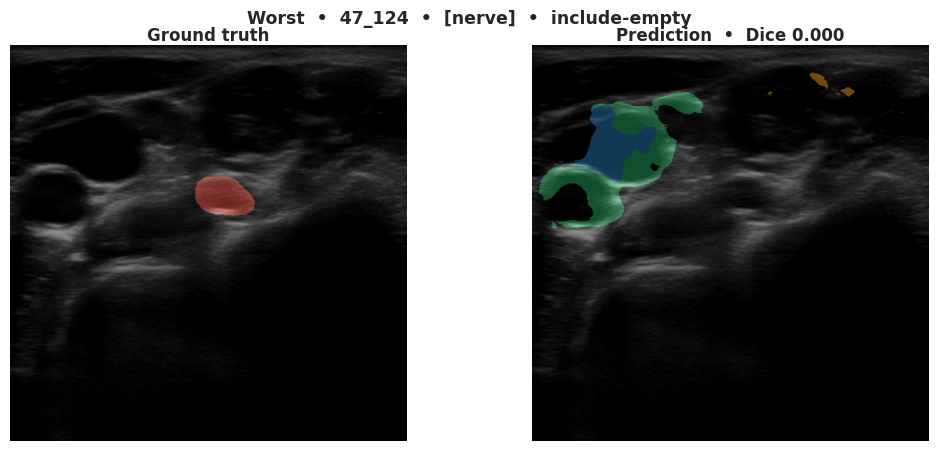

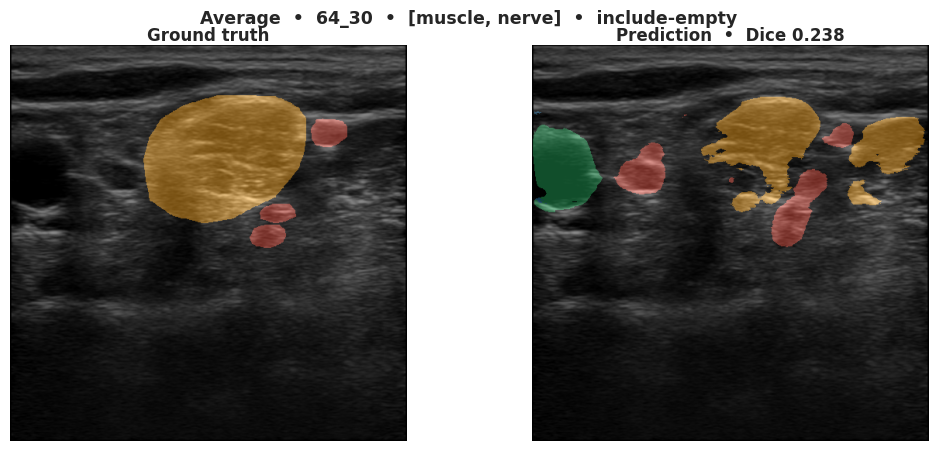

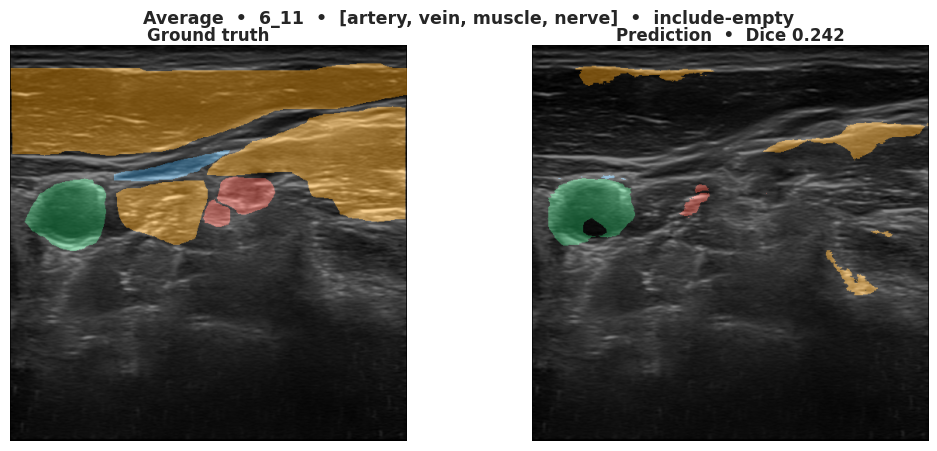

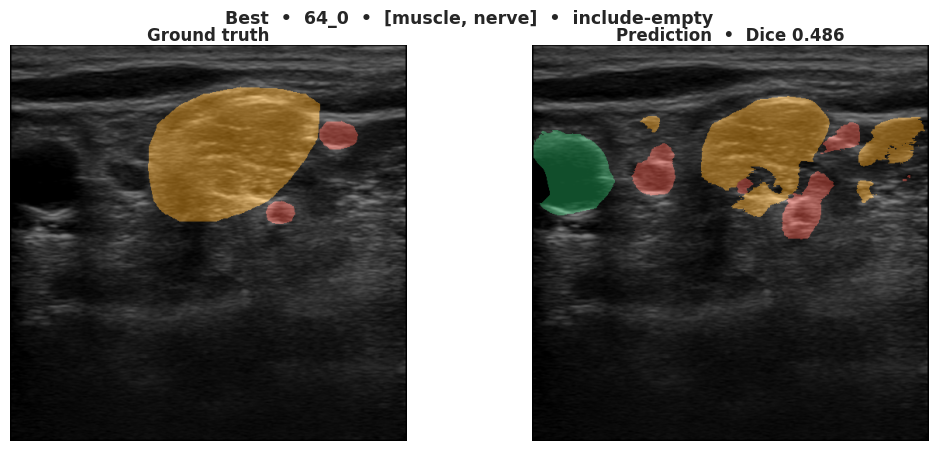

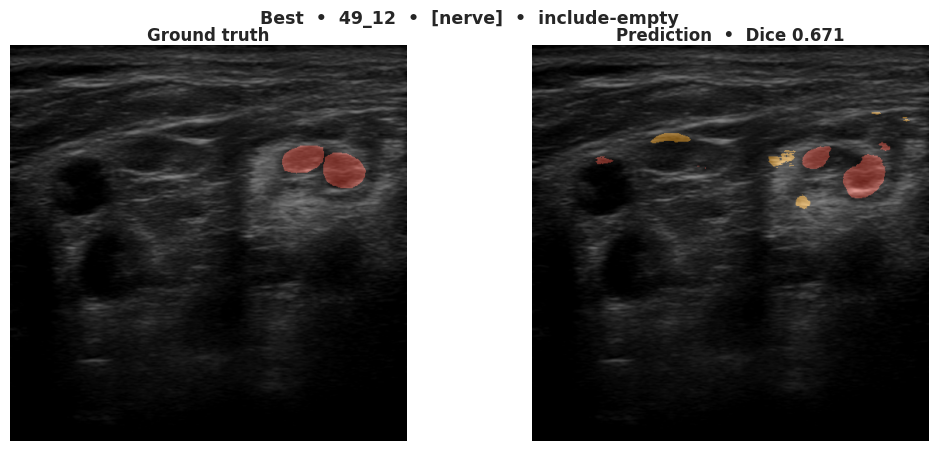

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



📂 Fold 2/5
  Train patient IDs: [50, 84, 58, 166, 69, 77, 87, 70, 98, 85, 1, 60, 71, 67, 61, 100, 92, 90, 48, 86, 62, 89, 96, 97, 52, 83, 93, 63, 3, 82, 65, 75, 4, 99, 94, 66]
  Val   patient IDs: [79, 88, 81, 2, 73, 68, 5, 51]

Train landmarks stat: 
Artery  present: 238/418 images
Vein    present: 211/418 images
Muscle  present: 309/418 images
Nerve   present: 407/418 images

Validation landmarks stat:
Artery  present: 46/88 images
Vein    present: 50/88 images
Muscle  present: 49/88 images
Nerve   present: 72/88 images


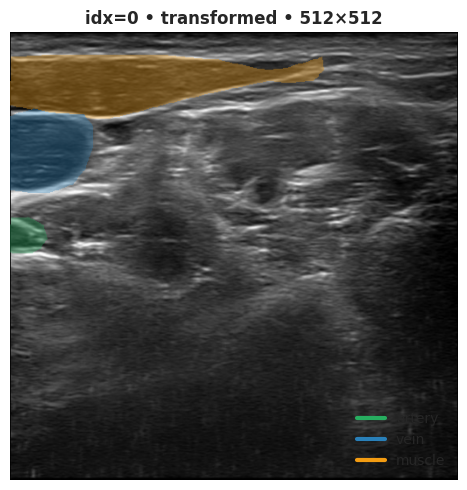

Epoch 001/100 | lr=1.000e-03 train_loss=0.7359 val_loss=0.4899 train_dice=0.1199 val_dice=0.3485 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.4738 val_loss=0.4195 train_dice=0.2879 val_dice=0.3292 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.3909 val_loss=0.3776 train_dice=0.2799 val_dice=0.2903 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.3543 val_loss=0.4036 train_dice=0.2781 val_dice=0.3216  (patience 1/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.3268 val_loss=0.3547 train_dice=0.3096 val_dice=0.2980 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.2953 val_loss=0.3249 train_dice=0.3449 val_dice=0.3031 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.2795 val_loss=0.2806 train_dice=0.3599 val_dice=0.3468 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.2588 val_loss=0.3596 train_dice=0.3630 val_dice=0.2575  (patience 1/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.2406 val_l

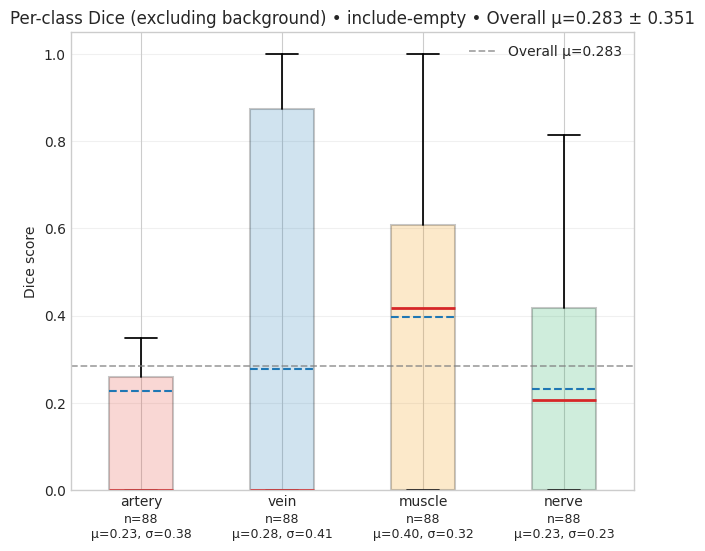

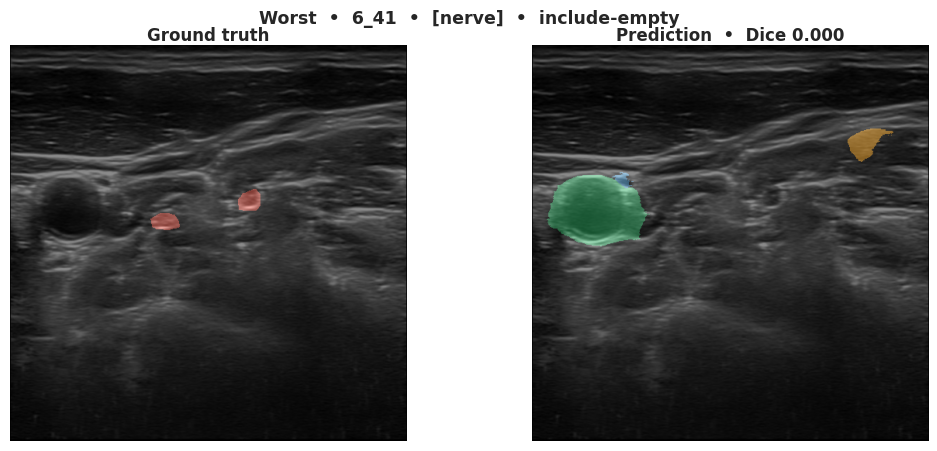

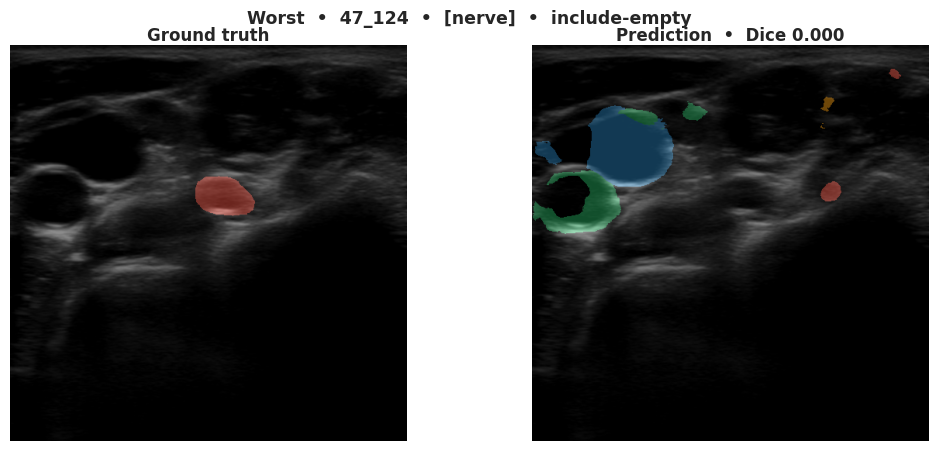

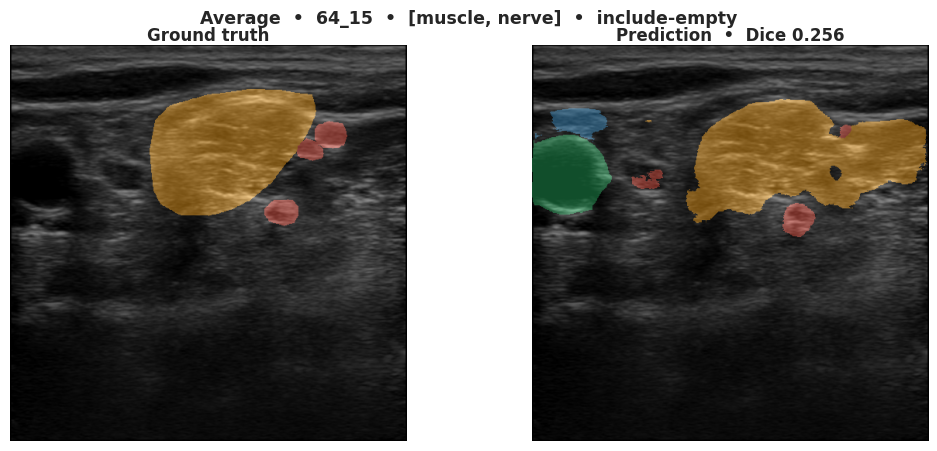

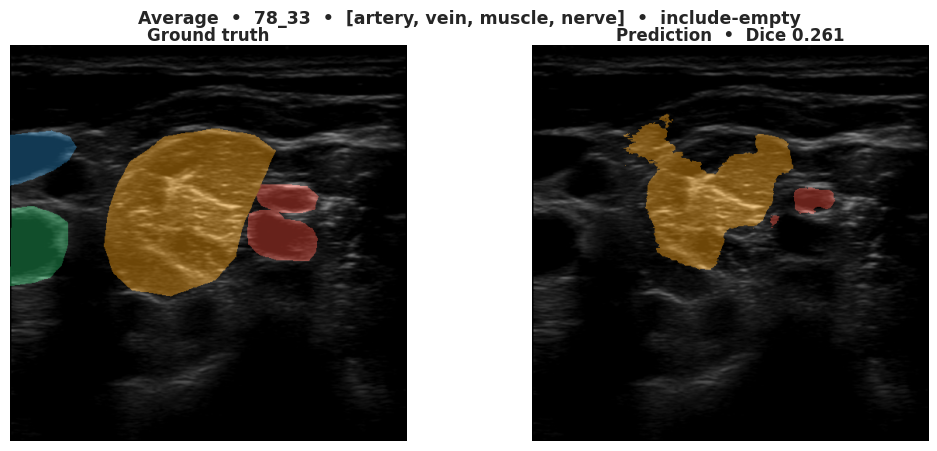

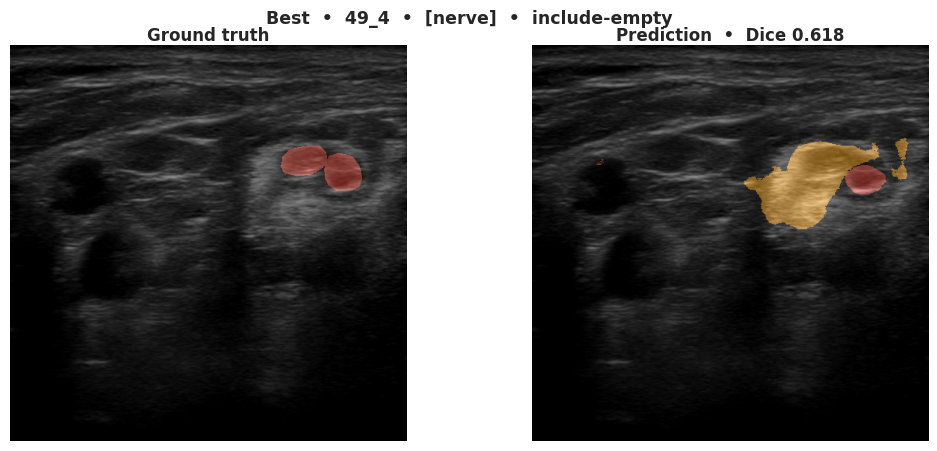

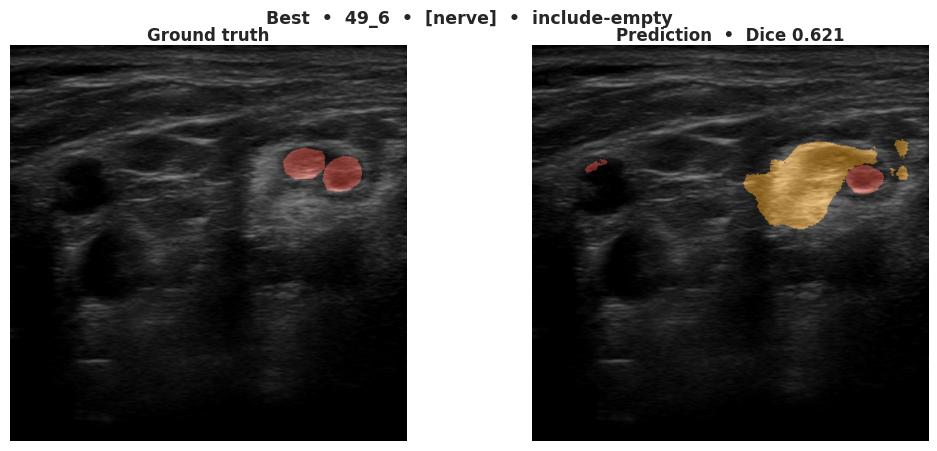

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.



📂 Fold 3/5
  Train patient IDs: [50, 84, 58, 166, 69, 77, 87, 70, 79, 88, 81, 2, 73, 68, 5, 51, 92, 90, 48, 86, 62, 89, 96, 97, 52, 83, 93, 63, 3, 82, 65, 75, 4, 99, 94, 66]
  Val   patient IDs: [98, 85, 1, 60, 71, 67, 61, 100]

Train landmarks stat: 
Artery  present: 219/403 images
Vein    present: 210/403 images
Muscle  present: 269/403 images
Nerve   present: 380/403 images

Validation landmarks stat:
Artery  present:  65/103 images
Vein    present:  51/103 images
Muscle  present:  89/103 images
Nerve   present:  99/103 images


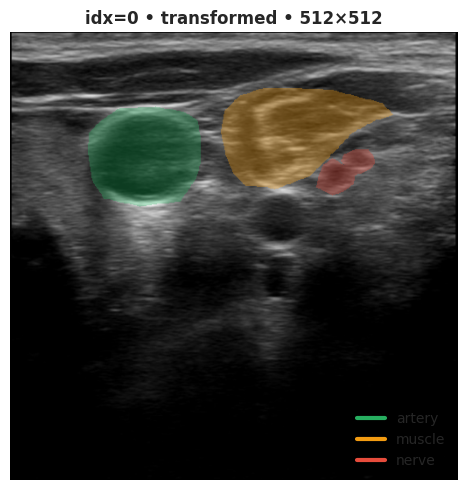

Epoch 001/100 | lr=1.000e-03 train_loss=0.5755 val_loss=0.5502 train_dice=0.1700 val_dice=0.2745 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.3718 val_loss=0.4252 train_dice=0.2423 val_dice=0.2329 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.3107 val_loss=0.3872 train_dice=0.2750 val_dice=0.3418 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.2820 val_loss=0.3726 train_dice=0.3061 val_dice=0.3383 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.2546 val_loss=0.4327 train_dice=0.3379 val_dice=0.3689  (patience 1/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.2260 val_loss=0.3908 train_dice=0.4250 val_dice=0.3173  (patience 2/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.2200 val_loss=0.3793 train_dice=0.4768 val_dice=0.3395  (patience 3/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.1925 val_loss=0.3676 train_dice=0.5268 val_dice=0.4123 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.1850 val_loss=0.

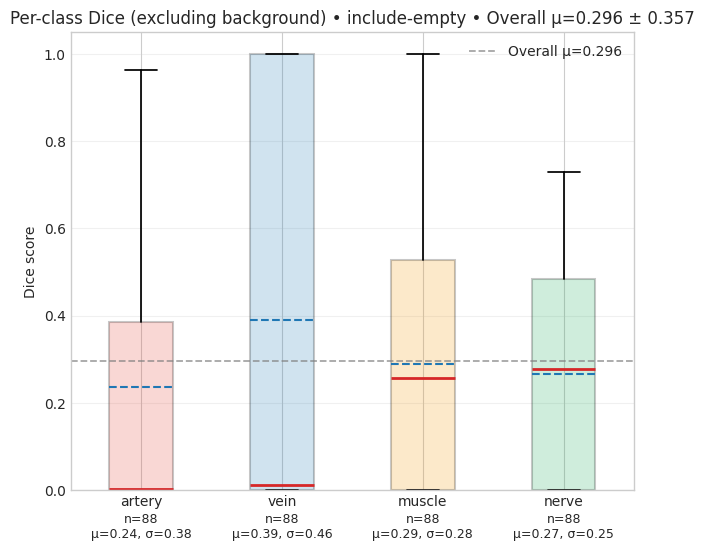

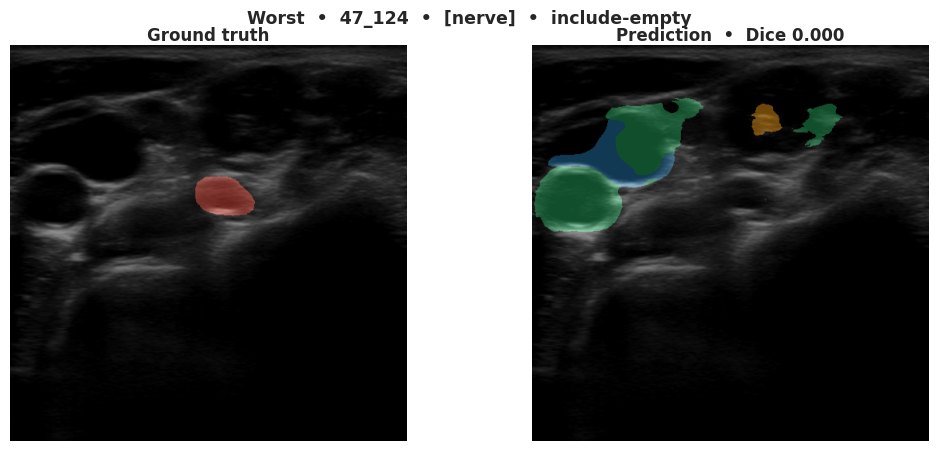

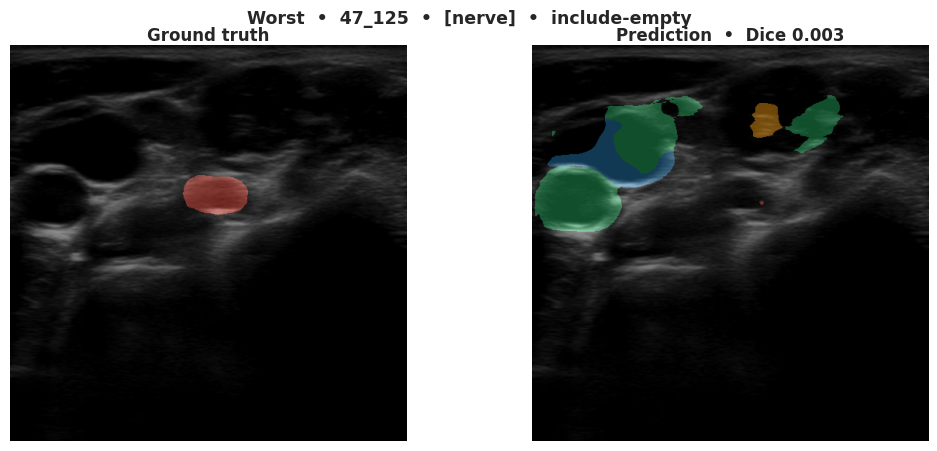

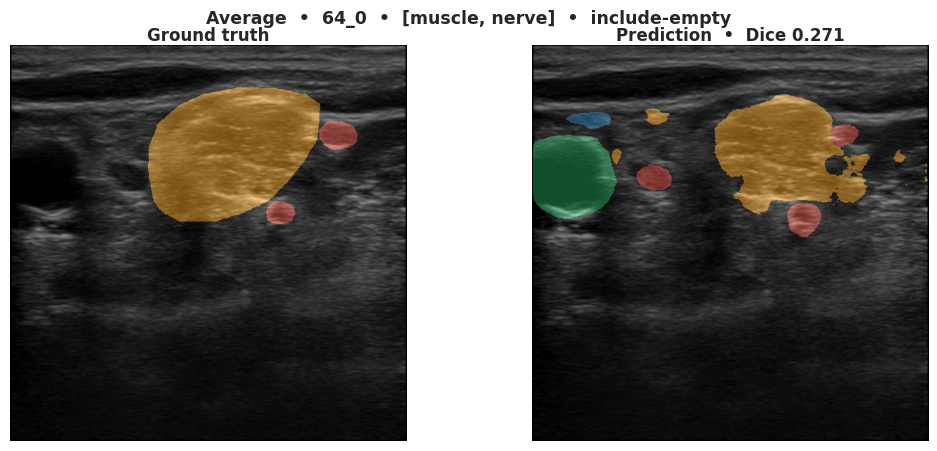

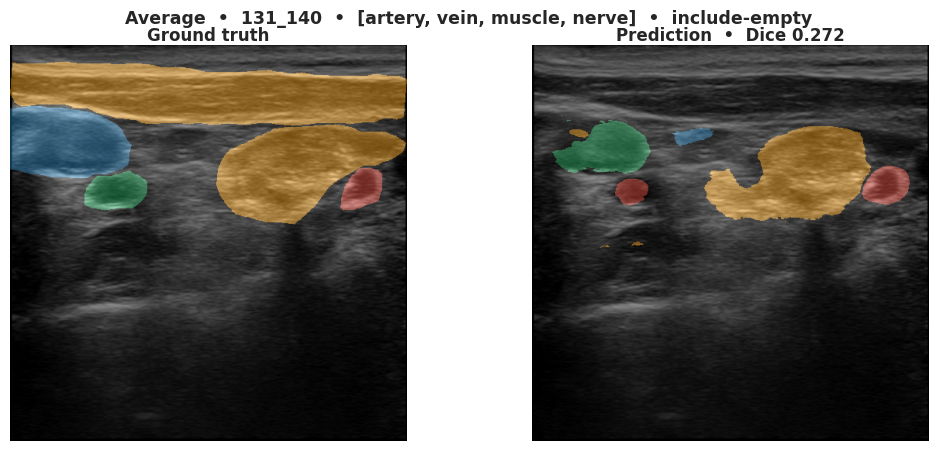

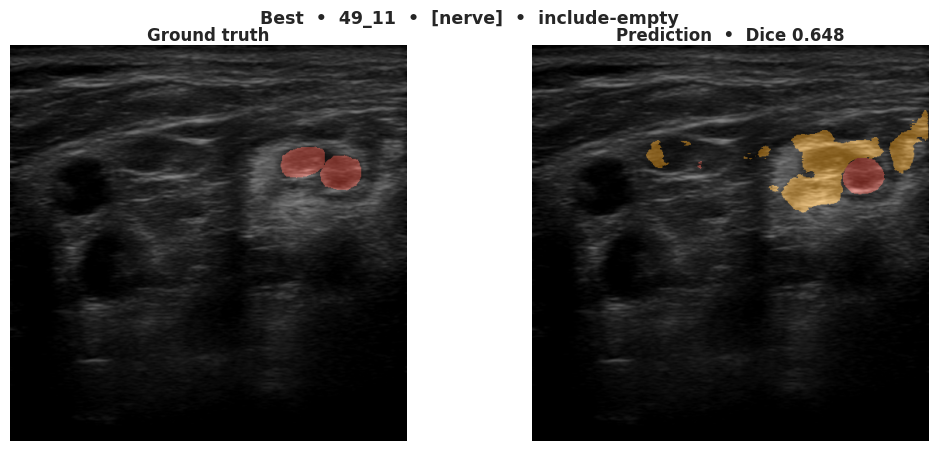

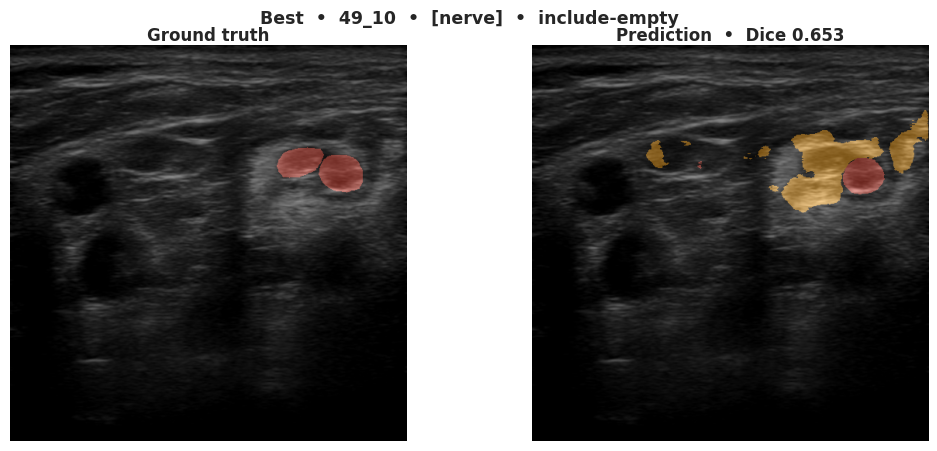

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.



📂 Fold 4/5
  Train patient IDs: [50, 84, 58, 166, 69, 77, 87, 70, 79, 88, 81, 2, 73, 68, 5, 51, 98, 85, 1, 60, 71, 67, 61, 100, 52, 83, 93, 63, 3, 82, 65, 75, 4, 99, 94, 66]
  Val   patient IDs: [92, 90, 48, 86, 62, 89, 96, 97]

Train landmarks stat: 
Artery  present: 245/423 images
Vein    present: 238/423 images
Muscle  present: 291/423 images
Nerve   present: 397/423 images

Validation landmarks stat:
Artery  present: 39/83 images
Vein    present: 23/83 images
Muscle  present: 67/83 images
Nerve   present: 82/83 images


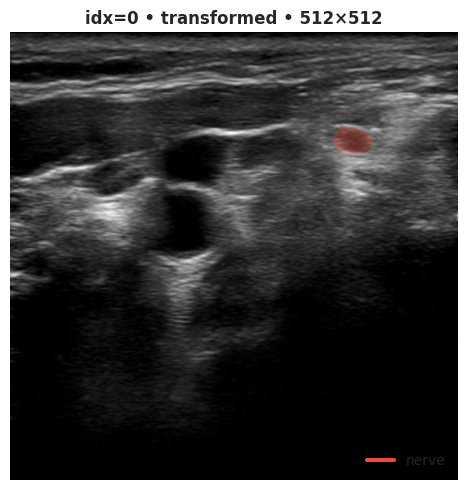

Epoch 001/100 | lr=1.000e-03 train_loss=1.1788 val_loss=0.9069 train_dice=0.0761 val_dice=0.2455 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.7182 val_loss=0.6075 train_dice=0.2106 val_dice=0.2935 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.5906 val_loss=0.5263 train_dice=0.2105 val_dice=0.2510 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.4997 val_loss=0.4669 train_dice=0.2323 val_dice=0.3229 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.4408 val_loss=0.4042 train_dice=0.2568 val_dice=0.3319 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.4094 val_loss=0.3707 train_dice=0.2665 val_dice=0.3648 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.3743 val_loss=0.3634 train_dice=0.3018 val_dice=0.2325 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.3549 val_loss=0.3749 train_dice=0.2989 val_dice=0.3160  (patience 1/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.3252

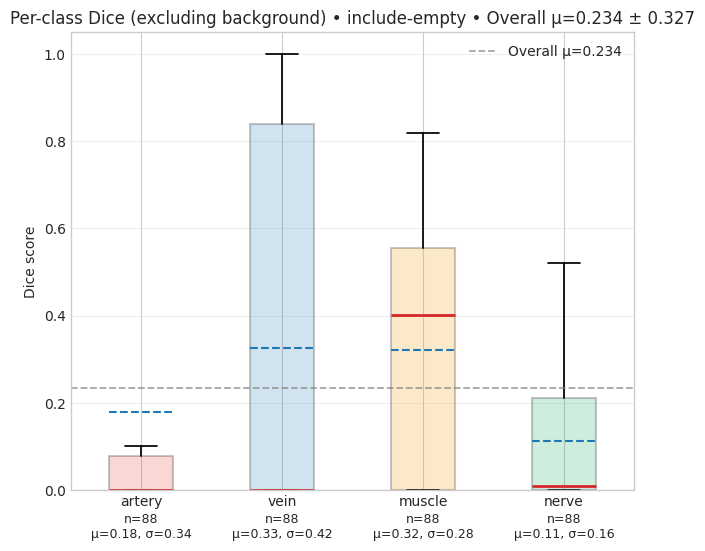

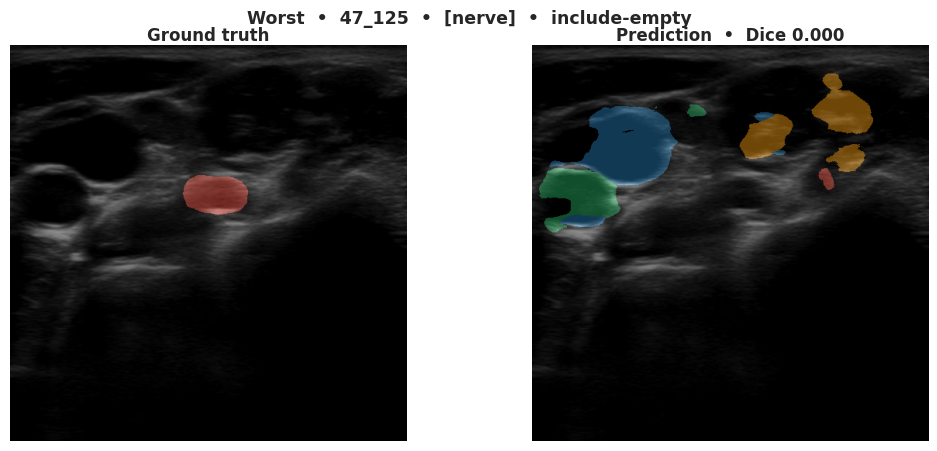

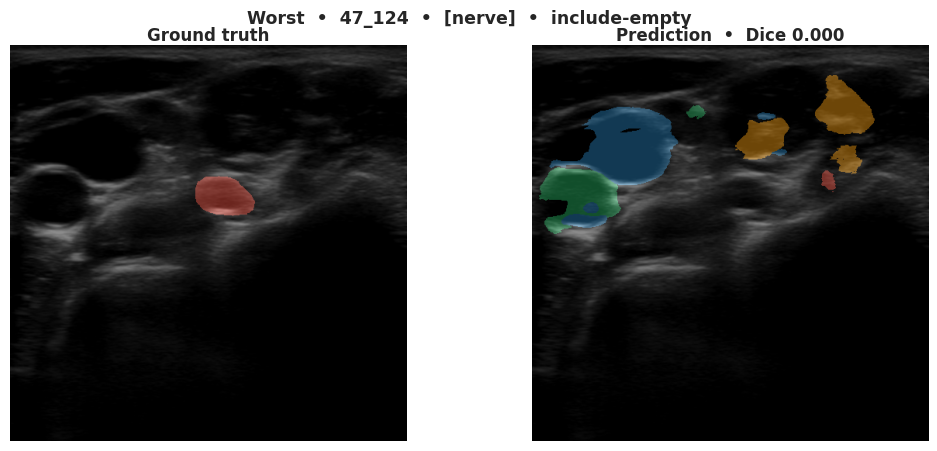

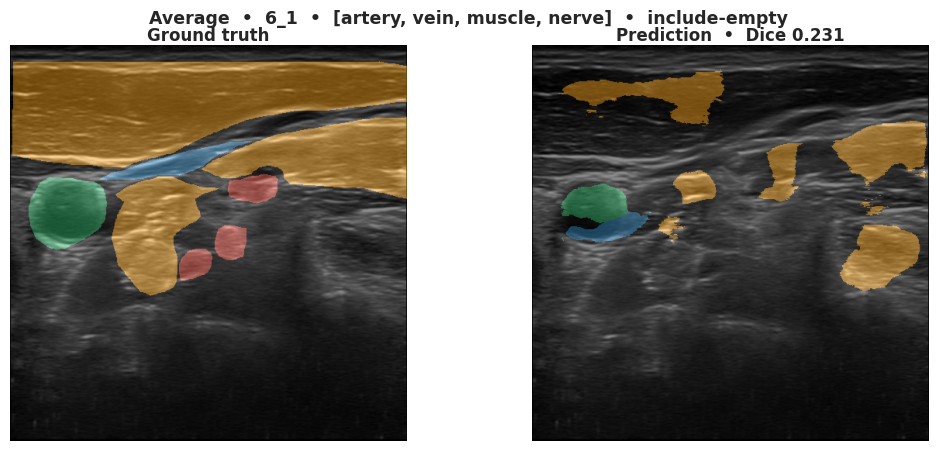

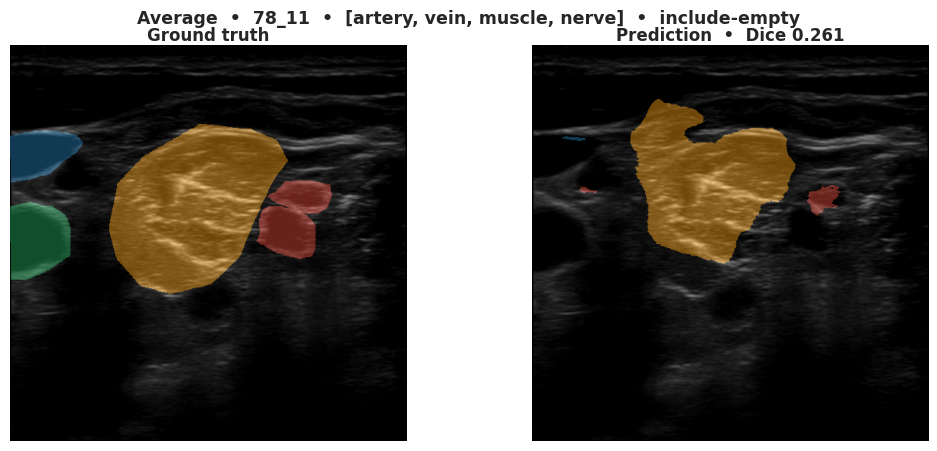

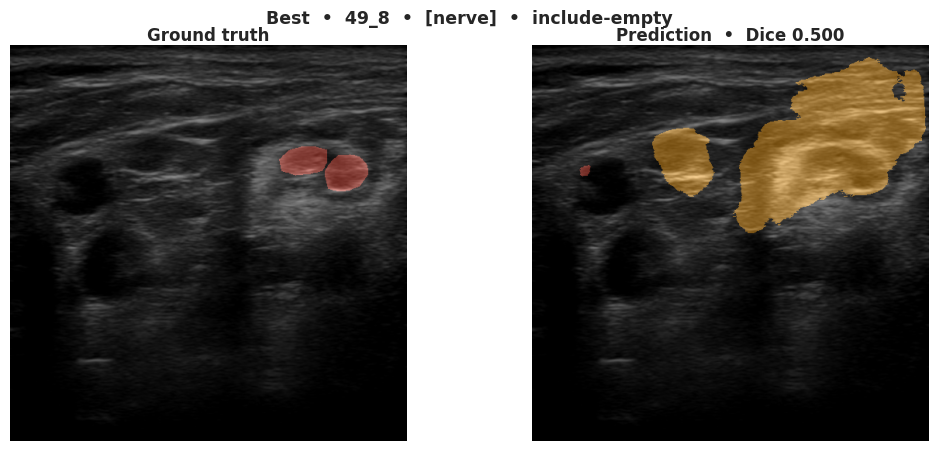

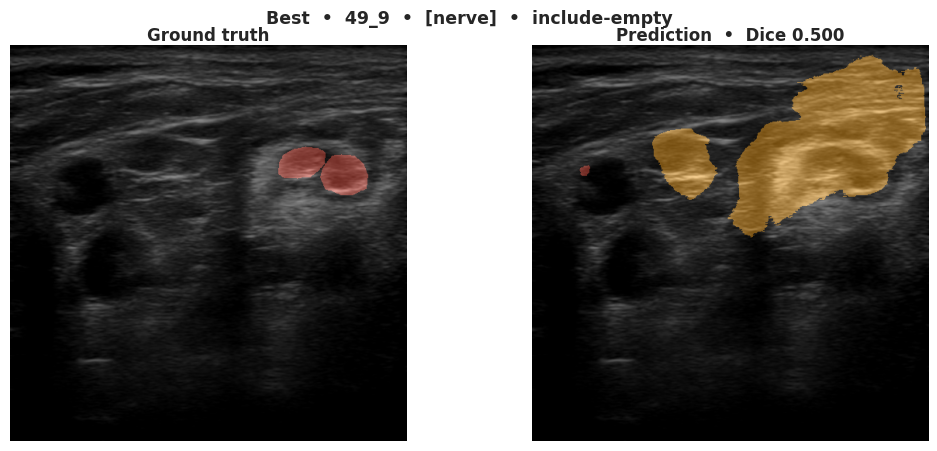

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.



📂 Fold 5/5
  Train patient IDs: [50, 84, 58, 166, 69, 77, 87, 70, 79, 88, 81, 2, 73, 68, 5, 51, 98, 85, 1, 60, 71, 67, 61, 100, 92, 90, 48, 86, 62, 89, 96, 97]
  Val   patient IDs: [52, 83, 93, 63, 3, 82, 65, 75, 4, 99, 94, 66]

Train landmarks stat: 
Artery  present: 173/348 images
Vein    present: 143/348 images
Muscle  present: 250/348 images
Nerve   present: 327/348 images

Validation landmarks stat:
Artery  present: 111/158 images
Vein    present: 118/158 images
Muscle  present: 108/158 images
Nerve   present: 152/158 images


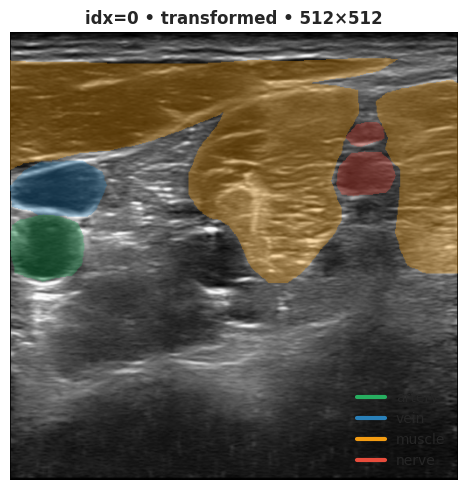

Epoch 001/100 | lr=1.000e-03 train_loss=0.9920 val_loss=1.4385 train_dice=0.0824 val_dice=0.0899 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.5534 val_loss=1.2834 train_dice=0.2117 val_dice=0.1554 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.4564 val_loss=2.0904 train_dice=0.2871 val_dice=0.1945  (patience 1/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.3977 val_loss=0.4913 train_dice=0.3131 val_dice=0.2234 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.3549 val_loss=0.5078 train_dice=0.3617 val_dice=0.1890  (patience 1/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.3394 val_loss=0.5329 train_dice=0.3580 val_dice=0.2765  (patience 2/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.2984 val_loss=0.6215 train_dice=0.3769 val_dice=0.2555  (patience 3/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.2901 val_loss=0.5217 train_dice=0.3672 val_dice=0.1976  (patience 4/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.2552 val_loss=0.3772 train_d

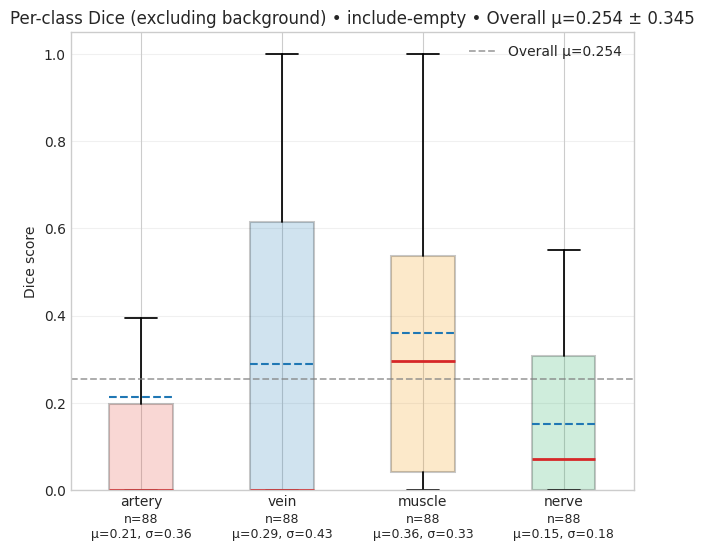

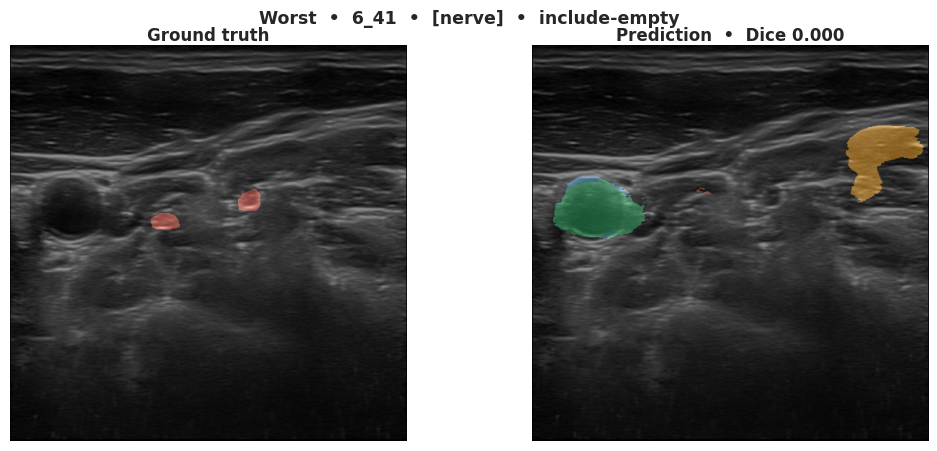

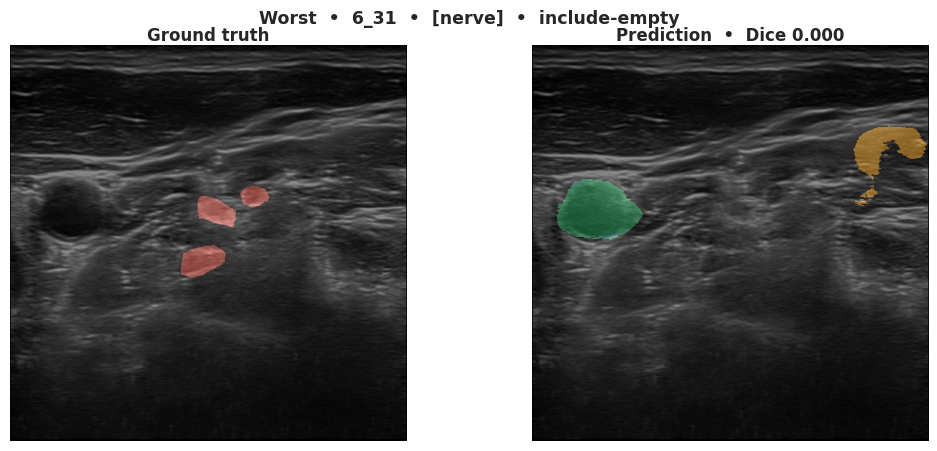

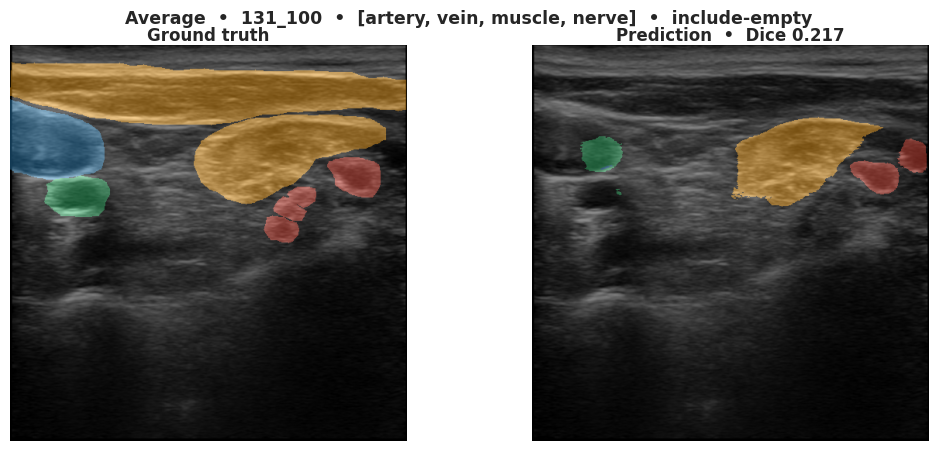

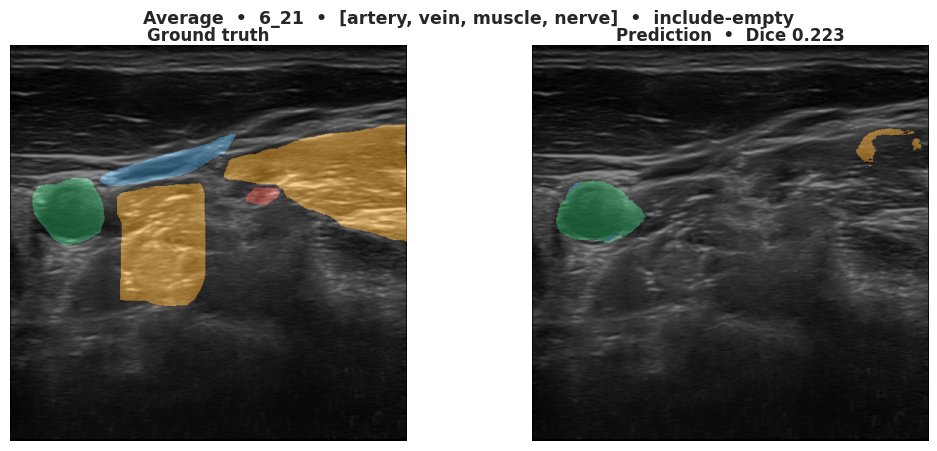

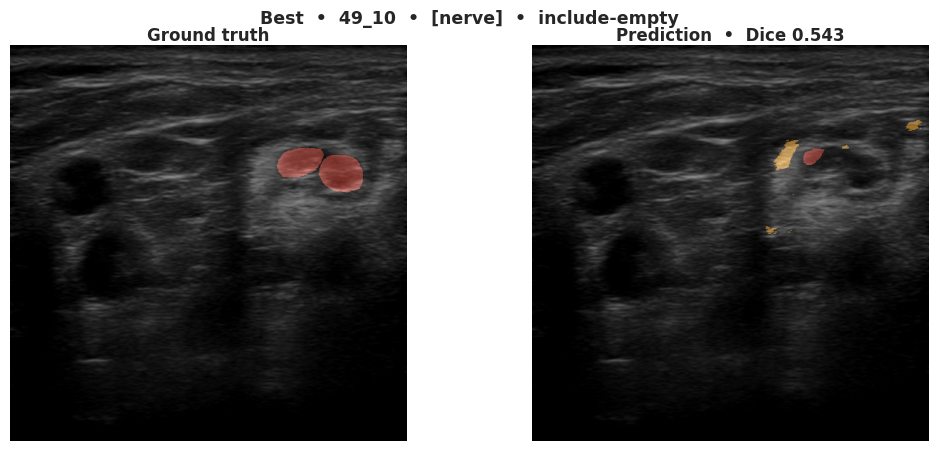

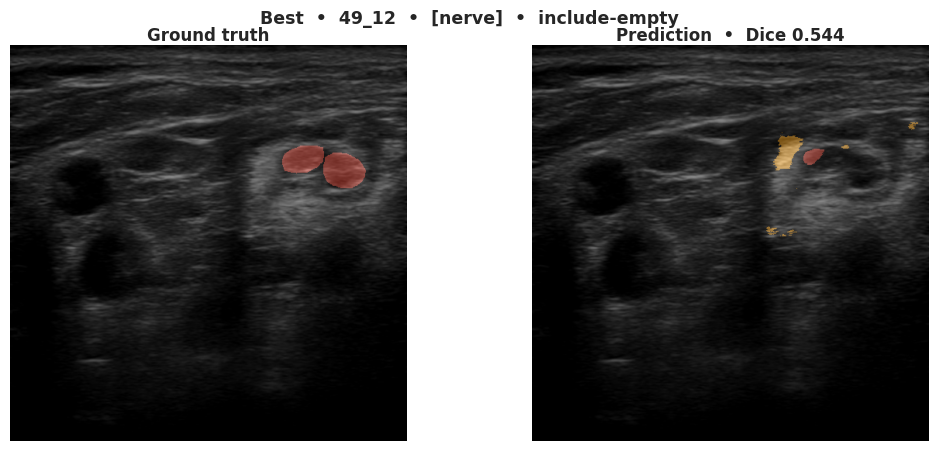

wandb: ERROR The nbformat package was not found. It is required to save notebook history.



🎯 Average overall Dice across folds: 0.2585 ± 0.0273  (n=5)

📌 Per-landmark average Dice across folds:
  1: dongmai (artery)     mean±std: 0.2000 ± 0.0350  (folds=5)
  2: jingmai (vein)       mean±std: 0.3042 ± 0.0511  (folds=5)
  3: jirouzuzhi (muscle)  mean±std: 0.3250 ± 0.0494  (folds=5)
  4: shenjing (nerve)     mean±std: 0.2049 ± 0.0620  (folds=5)

✅ Experiment complete across folds.


In [17]:
res = experiment(variants, exp_id=222204, seed=seed)

In [15]:
res["fold_overall_means"]

[0.3388568162918091,
 0.37606215476989746,
 0.35812509059906006,
 0.3421745300292969,
 0.33890366554260254]